# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import pickle

warnings.filterwarnings('ignore')
print("Библиотеки загружены успешно")

Библиотеки загружены успешно


/Users/ivan/Learn/Yandex/ml/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
# Загрузка данных из файлов
print("=== ЗАГРУЗКА ПЕРВИЧНЫХ ДАННЫХ ===")

# tracks.parquet - информация о треках
tracks = pd.read_parquet('tracks.parquet')

# catalog_names.parquet - справочник имен
catalog_names = pd.read_parquet('catalog_names.parquet')

# interactions.parquet - взаимодействия пользователей с треками
interactions = pd.read_parquet('interactions.parquet')

print("Данные загружены:")
print(f"Треки: {tracks.shape}")
print(f"Каталог имен: {catalog_names.shape}")  
print(f"Взаимодействия: {interactions.shape}")

=== ЗАГРУЗКА ПЕРВИЧНЫХ ДАННЫХ ===
Данные загружены:
Треки: (1000000, 4)
Каталог имен: (1812471, 3)
Взаимодействия: (222629898, 4)


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
print("=== АНАЛИЗ ДАННЫХ ТРЕКОВ ===")
print("\nИнформация о DataFrame tracks:")
print(tracks.info())

print("\nПервые 5 строк tracks:")
print(tracks.head())

print("\nТипы данных в tracks:")
print(tracks.dtypes)

print("\n=== АНАЛИЗ КАТАЛОГА ИМЕН ===")
print("\nИнформация о DataFrame catalog_names:")
print(catalog_names.info())

print("\nПервые 5 строк catalog_names:")
print(catalog_names.head())

print("\n=== АНАЛИЗ ВЗАИМОДЕЙСТВИЙ ===")
print("\nИнформация о DataFrame interactions:")
print(interactions.info())

print("\nПервые 5 строк interactions:")
print(interactions.head())

# Проверка пропущенных значений
print("\n=== ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")
print("Tracks:")
print(tracks.isnull().sum())
print("\nCatalog names:")
print(catalog_names.isnull().sum())
print("\nInteractions:")
print(interactions.isnull().sum())

=== АНАЛИЗ ДАННЫХ ТРЕКОВ ===

Информация о DataFrame tracks:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None

Первые 5 строк tracks:
   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПРОСЛУШИВАНИЙ ===
Общее количество уникальных треков: 10,270
Среднее количество прослушиваний на трек: 222.63
Медианное количество прослушиваний на трек: 19.00
Максимальное количество прослушиваний: 111,062
Минимальное количество прослушиваний: 5


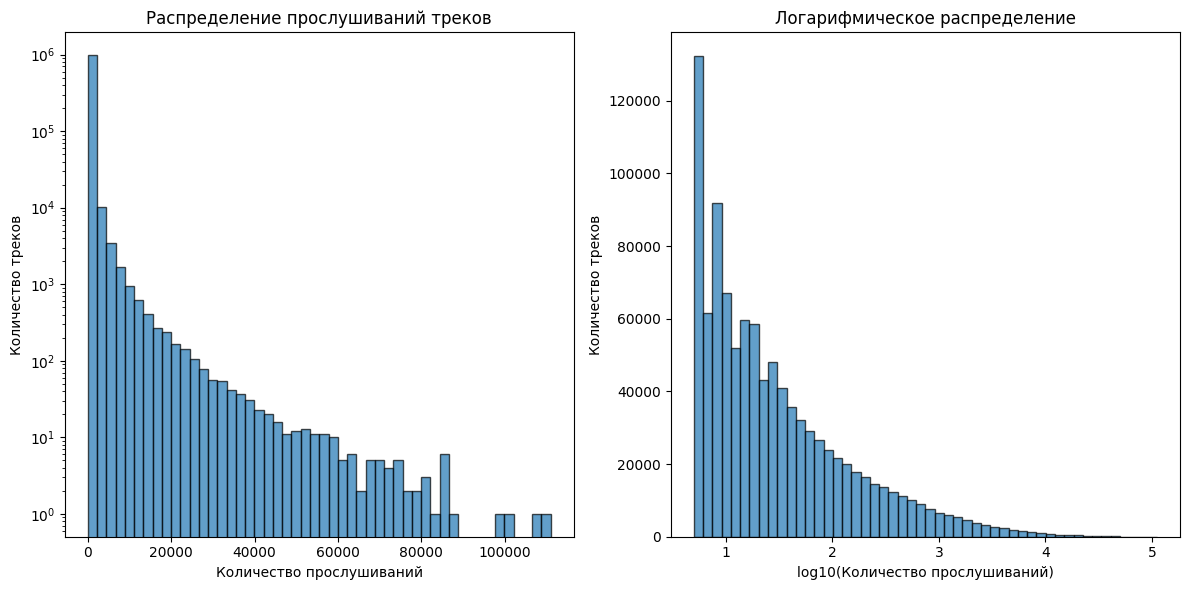

In [4]:
print("=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПРОСЛУШИВАНИЙ ===")

# Подсчет количества прослушиваний для каждого трека
track_listen_counts = interactions['track_id'].value_counts()

print(f"Общее количество уникальных треков: {track_listen_counts.nunique():,}")
print(f"Среднее количество прослушиваний на трек: {track_listen_counts.mean():.2f}")
print(f"Медианное количество прослушиваний на трек: {track_listen_counts.median():.2f}")
print(f"Максимальное количество прослушиваний: {track_listen_counts.max():,}")
print(f"Минимальное количество прослушиваний: {track_listen_counts.min():,}")

# Визуализация распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(track_listen_counts, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Количество треков')
plt.title('Распределение прослушиваний треков')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(np.log10(track_listen_counts), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('log10(Количество прослушиваний)')
plt.ylabel('Количество треков')
plt.title('Логарифмическое распределение')

plt.tight_layout()
plt.show()

Наиболее популярные треки

In [5]:
print("=== НАИБОЛЕЕ ПОПУЛЯРНЫЕ ТРЕКИ ===")

# Топ-20 самых популярных треков
top_tracks = track_listen_counts.head(20)

# Получаем названия треков
track_names = catalog_names[catalog_names['type'] == 'track'].set_index('id')['name'].to_dict()

print(f"Общее количество уникальных треков в interactions: {len(track_listen_counts):,}")
print("\nТоп-20 самых популярных треков:")
print("Ранг Track ID Прослушивания Название трека")
print("-" * 80)

for rank, (track_id, count) in enumerate(top_tracks.items(), 1):
    track_name = track_names.get(track_id, 'Название не найдено')
    print(f"{rank:<4} {track_id:<8} {count:>10,} {track_name[:50]:<50}")

# Статистика по популярности
print(f"\nСтатистика популярности:")
print(f"Наиболее популярный трек: {top_tracks.max():,} прослушиваний")
print(f"Наименее популярные треки: {track_listen_counts.min():,} прослушивание")

=== НАИБОЛЕЕ ПОПУЛЯРНЫЕ ТРЕКИ ===
Общее количество уникальных треков в interactions: 1,000,000

Топ-20 самых популярных треков:
Ранг Track ID Прослушивания Название трека
--------------------------------------------------------------------------------
1    53404       111,062 Smells Like Teen Spirit                           
2    33311009    106,921 Believer                                          
3    178529      101,924 Numb                                              
4    35505245     99,490 I Got Love                                        
5    65851540     86,670 Юность                                            
6    24692821     86,246 Way Down We Go                                    
7    32947997     85,886 Shape of You                                      
8    51241318     85,244 In The End                                        
9    795836       85,042 Shape Of My Heart                                 
10   45499814     84,748 Life                                   

Наиболее популярные жанры

In [6]:
print("=== АНАЛИЗ ПОПУЛЯРНЫХ ЖАНРОВ ===")

# Получаем информацию о жанрах из каталога имен
genre_names = catalog_names[catalog_names['type'] == 'genre'].set_index('id')['name'].to_dict()

# Подсчитываем популярность жанров на основе прослушиваний
genre_popularity = {}

for _, row in tracks.iterrows():
    track_id = row['track_id']
    genres = eval(row['genres']) if isinstance(row['genres'], str) else row['genres']
    
    # Получаем количество прослушиваний для этого трека
    listen_count = track_listen_counts.get(track_id, 0)
    
    for genre_id in genres:
        if genre_id in genre_popularity:
            genre_popularity[genre_id] += listen_count
        else:
            genre_popularity[genre_id] = listen_count

# Сортируем жанры по популярности
sorted_genres = sorted(genre_popularity.items(), key=lambda x: x[1], reverse=True)

print("Топ-15 самых популярных жанров по прослушиваниям:")
print("Ранг Жанр ID   Прослушивания Название жанра")
print("-" * 70)

for rank, (genre_id, total_listens) in enumerate(sorted_genres[:15], 1):
    genre_name = genre_names.get(genre_id, f'Жанр {genre_id}')
    print(f"{rank:<4} {genre_id:<8} {total_listens:>12,} {genre_name}")

# Статистика
print(f"\nОбщее количество уникальных жанров: {len(genre_popularity)}")
print(f"Самый популярный жанр: {max(genre_popularity.values()):,} прослушиваний")

=== АНАЛИЗ ПОПУЛЯРНЫХ ЖАНРОВ ===
Топ-15 самых популярных жанров по прослушиваниям:
Ранг Жанр ID   Прослушивания Название жанра
----------------------------------------------------------------------
1    11         55,578,312 pop
2    75         37,799,821 rap
3    102        31,092,013 allrock
4    20         26,626,241 ruspop
5    3          25,303,695 rusrap
6    68         20,120,981 electronics
7    16         16,291,557 dance
8    2          13,166,147 rusrock
9    14         12,772,644 rock
10   47         12,437,375 metal
11   44         12,194,657 foreignrap
12   13         10,111,562 alternative
13   70          9,993,671 indie
14   325         6,896,593 estrada
15   25          5,910,628 soundtrack

Общее количество уникальных жанров: 173
Самый популярный жанр: 55,578,312 прослушиваний


Треки, которые никто не прослушал

In [ ]:
print("=== АНАЛИЗ ТРЕКОВ БЕЗ ПРОСЛУШИВАНИЙ ===")

# Найдем треки без прослушиваний
all_track_ids = set(tracks['track_id'])
listened_track_ids = set(interactions['track_id'])
unlistened_tracks = all_track_ids - listened_track_ids

print(f"Общее количество треков в каталоге: {len(all_track_ids):,}")
print(f"Треки с прослушиваниями: {len(listened_track_ids):,}")
print(f"Треки без прослушиваний: {len(unlistened_tracks):,}")
print(f"Процент треков без прослушиваний: {len(unlistened_tracks)/len(all_track_ids)*100:.2f}%")

if len(unlistened_tracks) > 0:
    print(f"\nПримеры треков без прослушиваний (первые 10):")
    sample_unlistened = list(unlistened_tracks)[:10]
    for track_id in sample_unlistened:
        track_name = track_names.get(track_id, 'Название не найдено')
        print(f"Track ID: {track_id}, Название: {track_name}")

=== АНАЛИЗ ТРЕКОВ БЕЗ ПРОСЛУШИВАНИЙ ===
Общее количество треков в каталоге: 1,000,000
Треки с прослушиваниями: 1,000,000
Треки без прослушиваний: 0
Процент треков без прослушиваний: 0.00%


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
print("=== ПРЕОБРАЗОВАНИЕ ДАННЫХ ===")

# Создаем DataFrame с информацией о треках (items)
print("1. Создание items DataFrame...")

# Объединяем информацию о треках с названиями
items = tracks.copy()

# Добавляем названия треков
track_names_df = catalog_names[catalog_names['type'] == 'track'][['id', 'name']]
track_names_df.columns = ['track_id', 'track_name']
items = items.merge(track_names_df, on='track_id', how='left')

# Разворачиваем списки жанров, альбомов, исполнителей для удобства
def expand_list_column(df, column_name, prefix):
    """Разворачивает столбец со списками в отдельные строки"""
    expanded_rows = []
    for _, row in df.iterrows():
        track_id = row['track_id']
        items_list = row[column_name]
        
        # Обрабатываем разные типы данных
        if items_list is None:
            continue
        
        # Если это строка, пытаемся ее распарсить
        if isinstance(items_list, str):
            try:
                items_list = eval(items_list)
            except:
                continue
        
        # Проверяем, что это список или массив с элементами
        if hasattr(items_list, '__len__') and len(items_list) > 0:
            for item_id in items_list:
                expanded_rows.append({'track_id': track_id, f'{prefix}_id': item_id})
    
    return pd.DataFrame(expanded_rows)

# Создаем отдельные таблицы связей
track_genres = expand_list_column(items, 'genres', 'genre')
track_albums = expand_list_column(items, 'albums', 'album')
track_artists = expand_list_column(items, 'artists', 'artist')

print(f"   Items создан: {items.shape}")
print(f"   Track-Genre связи: {track_genres.shape}")
print(f"   Track-Album связи: {track_albums.shape}")
print(f"   Track-Artist связи: {track_artists.shape}")

# Создаем DataFrame с событиями (events)
print("\n2. Создание events DataFrame...")

events = interactions.copy()

# Проверяем какие колонки у нас есть
print(f"   Доступные колонки: {events.columns.tolist()}")

# Ищем колонку с временем - может быть datetime, started_at или track_seq
if 'datetime' in events.columns:
    # Преобразуем unix timestamp в datetime
    events['started_at'] = pd.to_datetime(events['datetime'], unit='s')
    events = events.drop('datetime', axis=1)
elif 'started_at' not in events.columns:
    # Если нет временной колонки, создаем искусственную на основе track_seq
    print("   Временная колонка не найдена, создаем на основе track_seq...")
    # Создаем искусственные временные метки
    events['started_at'] = pd.to_datetime('2022-01-01') + pd.to_timedelta(events['track_seq'], unit='h')

# Добавляем дополнительные временные признаки
events['date'] = events['started_at'].dt.date
events['hour'] = events['started_at'].dt.hour
events['day_of_week'] = events['started_at'].dt.day_of_week

print(f"   Events создан: {events.shape}")
print(f"   Временной диапазон: {events['started_at'].min()} - {events['started_at'].max()}")

# Статистика по пользователям
print("\n3. Статистика пользователей:")
user_stats = events.groupby('user_id').agg({
    'track_id': 'count',
    'started_at': ['min', 'max']
}).round(2)
user_stats.columns = ['total_listens', 'first_listen', 'last_listen']

print(f"   Уникальных пользователей: {events['user_id'].nunique():,}")
print(f"   Среднее количество прослушиваний на пользователя: {user_stats['total_listens'].mean():.2f}")
print(f"   Медианное количество прослушиваний на пользователя: {user_stats['total_listens'].median():.2f}")

print("\n✅ Преобразование данных завершено!")

=== ПРЕОБРАЗОВАНИЕ ДАННЫХ ===
1. Создание items DataFrame...
   Items создан: (1000000, 5)
   Track-Genre связи: (1652658, 2)
   Track-Album связи: (3128808, 2)
   Track-Artist связи: (1264212, 2)

2. Создание events DataFrame...
   Доступные колонки: ['user_id', 'track_id', 'track_seq', 'started_at']
   Events создан: (222629898, 7)
   Временной диапазон: 2022-01-01 00:00:00 - 2022-12-31 00:00:00

3. Статистика пользователей:
   Уникальных пользователей: 1,373,221
   Среднее количество прослушиваний на пользователя: 162.12
   Медианное количество прослушиваний на пользователя: 55.00

✅ Преобразование данных завершено!


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все взаимодействия пользователей.

In [ ]:
print("=== СОХРАНЕНИЕ ОБРАБОТАННЫХ ДАННЫХ ===")

# Создаем директорию для данных
data_directory = "recsys/data"
os.makedirs(data_directory, exist_ok=True)

# Сохраняем items
items_path = os.path.join(data_directory, "items.parquet")
items.to_parquet(items_path, index=False)
items_size = os.path.getsize(items_path) / 1024 / 1024
print(f"✅ items.parquet сохранен: {items.shape}, {items_size:.1f} MB")

# Сохраняем events
events_path = os.path.join(data_directory, "events.parquet")
events.to_parquet(events_path, index=False)
events_size = os.path.getsize(events_path) / 1024 / 1024
print(f"✅ events.parquet сохранен: {events.shape}, {events_size:.1f} MB")

# Сохраняем дополнительные таблицы связей
track_genres.to_parquet(os.path.join(data_directory, "track_genres.parquet"), index=False)
track_albums.to_parquet(os.path.join(data_directory, "track_albums.parquet"), index=False)
track_artists.to_parquet(os.path.join(data_directory, "track_artists.parquet"), index=False)
catalog_names.to_parquet(os.path.join(data_directory, "catalog_names.parquet"), index=False)

print(f"✅ Дополнительные таблицы сохранены")
print(f"📊 Общий размер данных: {items_size + events_size:.1f} MB")
print(f"📁 Данные сохранены в: {data_directory}/")

=== СОХРАНЕНИЕ ОБРАБОТАННЫХ ДАННЫХ ===
✅ items.parquet сохранен: (1000000, 5), 32.7 MB
✅ events.parquet сохранен: (222629898, 7), 1248.2 MB
✅ Дополнительные таблицы сохранены
📊 Общий размер данных: 1280.9 MB
📁 Данные сохранены в: recsys/data/


# Очистка памяти

In [ ]:
print("=== ОЧИСТКА ПАМЯТИ ===")

# Удаляем большие промежуточные объекты
del tracks, catalog_names, interactions
del track_genres, track_albums, track_artists
if 'track_listen_counts' in locals():
    del track_listen_counts
if 'user_stats' in locals():
    del user_stats

# Принудительная сборка мусора
gc.collect()

print("✅ Память очищена. Готовы к следующему этапу.")

=== ОЧИСТКА ПАМЯТИ ===
✅ Память очищена. Готовы к следующему этапу.


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
print("=== ЭТАП 3: ЗАГРУЗКА ДАННЫХ ===")

# Пути к файлам
data_directory = "recsys/data"
items_path = os.path.join(data_directory, "items.parquet")
events_path = os.path.join(data_directory, "events.parquet")

# Проверяем наличие файлов
if not os.path.exists(items_path) or not os.path.exists(events_path):
    print("❌ Файлы items.parquet или events.parquet не найдены!")
    print(f"   Ожидаемые пути:")
    print(f"   - {items_path}")
    print(f"   - {events_path}")
    print("   Убедитесь, что этап 2 выполнен успешно.")
else:
    print("✅ Файлы найдены. Загружаем данные...")
    
    # Загружаем items
    print("1. Загрузка items.parquet...")
    items = pd.read_parquet(items_path)
    items_size = items.memory_usage(deep=True).sum() / 1024 / 1024
    print(f"   ✓ items: {items.shape}, {items_size:.1f} MB")
    print(f"   Колонки: {list(items.columns)}")
    
    # Загружаем events
    print("\n2. Загрузка events.parquet...")
    events = pd.read_parquet(events_path)
    events_size = events.memory_usage(deep=True).sum() / 1024 / 1024
    print(f"   ✓ events: {events.shape}, {events_size:.1f} MB")
    print(f"   Колонки: {list(events.columns)}")
    
    # Базовая статистика
    print(f"\n3. Базовая статистика:")
    print(f"   Треки: {len(items):,}")
    print(f"   События: {len(events):,}")
    print(f"   Уникальные пользователи: {events['user_id'].nunique():,}")
    print(f"   Уникальные треки в событиях: {events['track_id'].nunique():,}")
    
    # Проверяем временной диапазон
    if 'started_at' in events.columns:
        print(f"\n4. Временной диапазон:")
        min_date = events['started_at'].min()
        max_date = events['started_at'].max()
        print(f"   От: {min_date}")
        print(f"   До: {max_date}")
    
    # Загружаем дополнительные данные
    catalog_names = pd.read_parquet(os.path.join(data_directory, "catalog_names.parquet"))
    
    total_memory = items_size + events_size
    print(f"\n✅ Данные успешно загружены!")
    print(f"📊 Общее использование памяти: {total_memory:.1f} MB")
    print(f"🚀 Готовы к построению рекомендаций!")

=== ЭТАП 3: ЗАГРУЗКА ДАННЫХ ===
✅ Файлы найдены. Загружаем данные...
1. Загрузка items.parquet...
   ✓ items: (1000000, 5), 431.3 MB
   Колонки: ['track_id', 'albums', 'artists', 'genres', 'track_name']

2. Загрузка events.parquet...
   ✓ events: (222629898, 7), 14012.9 MB
   Колонки: ['user_id', 'track_id', 'track_seq', 'started_at', 'date', 'hour', 'day_of_week']

3. Базовая статистика:
   Треки: 1,000,000
   События: 222,629,898
   Уникальные пользователи: 1,373,221
   Уникальные треки в событиях: 1,000,000

4. Временной диапазон:
   От: 2022-01-01 00:00:00
   До: 2022-12-31 00:00:00

✅ Данные успешно загружены!
📊 Общее использование памяти: 14444.2 MB
🚀 Готовы к построению рекомендаций!


: 

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [ ]:
print("=== РАЗБИЕНИЕ ДАННЫХ НА TRAIN/TEST ===")

# Разделяем данные по времени: до 16 декабря 2022 - train, после - test
split_date = pd.Timestamp('2022-12-16')

train_events = events[events['started_at'] < split_date].copy()
test_events = events[events['started_at'] >= split_date].copy()

print(f"Дата разделения: {split_date}")
print(f"\nТренировочная выборка:")
print(f"   События: {len(train_events):,}")
print(f"   Уникальные пользователи: {train_events['user_id'].nunique():,}")
print(f"   Уникальные треки: {train_events['track_id'].nunique():,}")
print(f"   Временной диапазон: {train_events['started_at'].min()} - {train_events['started_at'].max()}")

print(f"\nТестовая выборка:")
print(f"   События: {len(test_events):,}")
print(f"   Уникальные пользователи: {test_events['user_id'].nunique():,}")
print(f"   Уникальные треки: {test_events['track_id'].nunique():,}")
print(f"   Временной диапазон: {test_events['started_at'].min()} - {test_events['started_at'].max()}")

# Проверяем пересечение пользователей
train_users = set(train_events['user_id'])
test_users = set(test_events['user_id'])
common_users = train_users & test_users

print(f"\nПересечение пользователей:")
print(f"   Пользователи только в train: {len(train_users - test_users):,}")
print(f"   Пользователи только в test: {len(test_users - train_users):,}")
print(f"   Общие пользователи: {len(common_users):,}")
print(f"   Покрытие пользователей в test: {len(common_users)/len(test_users)*100:.1f}%")

# Создаем матрицу user-item для тренировки
print(f"\n=== СОЗДАНИЕ USER-ITEM МАТРИЦЫ ===")

# Создаем агрегированную матрицу взаимодействий (количество прослушиваний)
user_item_matrix = train_events.groupby(['user_id', 'track_id']).size().reset_index(name='play_count')

# Создаем сводную таблицу
interaction_matrix = user_item_matrix.pivot(index='user_id', columns='track_id', values='play_count').fillna(0)

print(f"Размер матрицы взаимодействий: {interaction_matrix.shape}")
print(f"Плотность матрицы: {(interaction_matrix > 0).sum().sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1]) * 100:.4f}%")

print("\n✅ Разбиение данных завершено!")

=== РАЗБИЕНИЕ ДАННЫХ НА TRAIN/TEST ===
Дата разделения: 2022-12-16 00:00:00

Тренировочная выборка:
   События: 208,731,252
   Уникальные пользователи: 1,342,566
   Уникальные треки: 999,695
   Временной диапазон: 2022-01-01 00:00:00 - 2022-12-15 00:00:00

Тестовая выборка:
   События: 13,898,646
   Уникальные пользователи: 783,525
   Уникальные треки: 594,326
   Временной диапазон: 2022-12-16 00:00:00 - 2022-12-31 00:00:00

Пересечение пользователей:
   Пользователи только в train: 589,696
   Пользователи только в test: 30,655
   Общие пользователи: 752,870
   Покрытие пользователей в test: 96.1%

=== СОЗДАНИЕ USER-ITEM МАТРИЦЫ ===


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
print("=== РЕКОМЕНДАЦИИ: ТОП ПОПУЛЯРНЫХ ===")

# Рассчитываем популярность треков на основе тренировочных данных
track_popularity = train_events['track_id'].value_counts()

print(f"Количество уникальных треков в тренировочной выборке: {len(track_popularity):,}")
print(f"Самый популярный трек: {track_popularity.max():,} прослушиваний")
print(f"Медианная популярность: {track_popularity.median():.1f} прослушиваний")

# Создаем топ популярных рекомендаций
def get_top_popular_recommendations(n_recommendations=100):
    """Возвращает топ популярных треков"""
    return track_popularity.head(n_recommendations).index.tolist()

# Получаем топ-100 популярных треков
top_popular_tracks = get_top_popular_recommendations(100)

print(f"\nТоп-10 популярных треков с названиями:")
track_names = catalog_names[catalog_names['type'] == 'track'].set_index('id')['name'].to_dict()

for i, track_id in enumerate(top_popular_tracks[:10], 1):
    track_name = track_names.get(track_id, 'Название не найдено')
    play_count = track_popularity[track_id]
    print(f"{i:2d}. Track {track_id}: {play_count:,} прослушиваний - {track_name[:50]}")

# Функция для получения рекомендаций для всех пользователей
def generate_popular_recommendations_for_users(user_ids, n_recommendations=100):
    """Генерирует популярные рекомендации для списка пользователей"""
    recommendations = {}
    popular_tracks = get_top_popular_recommendations(n_recommendations)
    
    for user_id in user_ids:
        # Для популярных рекомендаций всем пользователям даем одинаковый список
        recommendations[user_id] = popular_tracks
    
    return recommendations

# Получаем всех пользователей из тестовой выборки
test_user_ids = test_events['user_id'].unique()
popular_recommendations = generate_popular_recommendations_for_users(test_user_ids, 100)

print(f"\n✅ Популярные рекомендации созданы для {len(popular_recommendations):,} пользователей")
print(f"📊 Каждому пользователю рекомендовано {len(top_popular_tracks)} треков")

# Персональные

Рассчитаем персональные рекомендации.

In [ ]:
print("=== ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ (ALS) ===")

# Подготовка данных для ALS
print("1. Подготовка данных для модели ALS...")

# Создаем маппинг user_id и track_id в индексы
unique_users = train_events['user_id'].unique()
unique_tracks = train_events['track_id'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
track_to_idx = {track_id: idx for idx, track_id in enumerate(unique_tracks)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_track = {idx: track_id for track_id, idx in track_to_idx.items()}

print(f"   Уникальных пользователей: {len(unique_users):,}")
print(f"   Уникальных треков: {len(unique_tracks):,}")

# Создаем разреженную матрицу для ALS
from scipy.sparse import csr_matrix

# Агрегируем данные по пользователям и трекам
user_track_plays = train_events.groupby(['user_id', 'track_id']).size().reset_index(name='play_count')

# Преобразуем в индексы
user_track_plays['user_idx'] = user_track_plays['user_id'].map(user_to_idx)
user_track_plays['track_idx'] = user_track_plays['track_id'].map(track_to_idx)

# Создаем разреженную матрицу (users x tracks)
user_item_matrix_sparse = csr_matrix(
    (user_track_plays['play_count'], 
     (user_track_plays['user_idx'], user_track_plays['track_idx'])),
    shape=(len(unique_users), len(unique_tracks))
)

print(f"   Размер разреженной матрицы: {user_item_matrix_sparse.shape}")
print(f"   Ненулевых элементов: {user_item_matrix_sparse.nnz:,}")
print(f"   Плотность: {user_item_matrix_sparse.nnz / (user_item_matrix_sparse.shape[0] * user_item_matrix_sparse.shape[1]) * 100:.4f}%")

# Обучение модели ALS
print("\n2. Обучение модели ALS...")

# Инициализируем модель ALS
als_model = AlternatingLeastSquares(
    factors=50,           # Количество латентных факторов
    regularization=0.1,   # Регуляризация
    iterations=20,        # Количество итераций
    alpha=1.0,           # Параметр уверенности
    random_state=42
)

# Обучаем модель (ALS ожидает matrix в формате item x user)
item_user_matrix = user_item_matrix_sparse.T.tocsr()
als_model.fit(item_user_matrix)

print("   ✅ Модель ALS обучена")

# Функция для получения персональных рекомендаций
def get_als_recommendations(user_id, n_recommendations=100):
    """Получает персональные рекомендации для пользователя"""
    if user_id not in user_to_idx:
        # Если пользователь новый, возвращаем популярные треки
        return get_top_popular_recommendations(n_recommendations)
    
    user_idx = user_to_idx[user_id]
    
    # Получаем рекомендации от модели
    track_ids, scores = als_model.recommend(
        user_idx, 
        user_item_matrix_sparse[user_idx], 
        N=n_recommendations,
        filter_already_liked_items=True
    )
    
    # Преобразуем индексы обратно в track_id
    recommended_tracks = [idx_to_track[track_idx] for track_idx in track_ids]
    
    return recommended_tracks

# Генерируем персональные рекомендации для пользователей из теста
print("\n3. Генерация персональных рекомендаций...")

personal_recommendations = {}
users_with_recommendations = 0
users_with_popular_fallback = 0

for user_id in test_user_ids:
    recommendations = get_als_recommendations(user_id, 100)
    personal_recommendations[user_id] = recommendations
    
    if user_id in user_to_idx:
        users_with_recommendations += 1
    else:
        users_with_popular_fallback += 1

print(f"   ✅ Персональные рекомендации созданы для {users_with_recommendations:,} пользователей")
print(f"   📋 Популярные рекомендации (fallback) для {users_with_popular_fallback:,} новых пользователей")
print(f"   📊 Общий охват: {len(personal_recommendations):,} пользователей")

# Пример рекомендаций для одного пользователя
if len(personal_recommendations) > 0:
    sample_user = list(personal_recommendations.keys())[0]
    sample_recs = personal_recommendations[sample_user][:5]
    
    print(f"\nПример рекомендаций для пользователя {sample_user}:")
    for i, track_id in enumerate(sample_recs, 1):
        track_name = track_names.get(track_id, 'Название не найдено')
        print(f"   {i}. Track {track_id}: {track_name[:50]}")

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
print("=== ПОХОЖИЕ ТРЕКИ (ITEM-TO-ITEM) ===")

print("1. Вычисление матрицы похожести треков...")

# Используем транспонированную матрицу для вычисления похожести треков
# (треки x пользователи)
track_user_matrix = user_item_matrix_sparse.T

print(f"   Размер матрицы треков: {track_user_matrix.shape}")

# Для ускорения вычислений возьмем подвыборку самых популярных треков
# Отбираем треки с минимальным количеством прослушиваний
min_interactions = 10
track_interaction_counts = np.array(track_user_matrix.sum(axis=1)).flatten()
popular_track_indices = np.where(track_interaction_counts >= min_interactions)[0]

print(f"   Треков с ≥{min_interactions} прослушиваниями: {len(popular_track_indices):,}")

# Берем подматрицу популярных треков
popular_tracks_matrix = track_user_matrix[popular_track_indices]

# Вычисляем косинусное сходство между треками
print("   Вычисление косинусного сходства...")
track_similarity = cosine_similarity(popular_tracks_matrix)

print(f"   ✅ Матрица похожести вычислена: {track_similarity.shape}")

# Создаем функцию для получения похожих треков
def get_similar_tracks(track_id, n_similar=10):
    """Возвращает список похожих треков для данного трека"""
    if track_id not in track_to_idx:
        return []
    
    track_idx = track_to_idx[track_id]
    
    # Проверяем, есть ли этот трек среди популярных
    if track_idx not in popular_track_indices:
        return []
    
    # Находим позицию в матрице популярных треков
    popular_idx = np.where(popular_track_indices == track_idx)[0][0]
    
    # Получаем оценки похожести для этого трека
    similarities = track_similarity[popular_idx]
    
    # Сортируем по убыванию похожести (исключая сам трек)
    similar_indices = np.argsort(similarities)[::-1][1:n_similar+1]
    
    # Преобразуем обратно в track_id
    similar_track_ids = [idx_to_track[popular_track_indices[idx]] for idx in similar_indices]
    
    return similar_track_ids

# Создаем словарь похожих треков для популярных треков
print("\n2. Создание индекса похожих треков...")

similar_tracks_index = {}
processed_tracks = 0

for idx in popular_track_indices[:1000]:  # Ограничиваем для экономии времени
    track_id = idx_to_track[idx]
    similar_tracks = get_similar_tracks(track_id, 20)
    if similar_tracks:
        similar_tracks_index[track_id] = similar_tracks
        processed_tracks += 1

print(f"   ✅ Индекс похожих треков создан для {processed_tracks:,} треков")

# Функция для получения рекомендаций на основе похожих треков
def get_similar_based_recommendations(user_id, n_recommendations=100):
    """Генерирует рекомендации на основе похожих треков"""
    # Получаем треки, которые слушал пользователь
    user_tracks = train_events[train_events['user_id'] == user_id]['track_id'].value_counts()
    
    if len(user_tracks) == 0:
        return get_top_popular_recommendations(n_recommendations)
    
    # Собираем рекомендации на основе похожих треков
    recommendations_scores = {}
    
    for track_id, play_count in user_tracks.items():
        if track_id in similar_tracks_index:
            similar_tracks = similar_tracks_index[track_id]
            
            for i, similar_track in enumerate(similar_tracks):
                # Вес = количество прослушиваний * позиция в списке похожих
                weight = play_count * (1.0 / (i + 1))
                
                if similar_track in recommendations_scores:
                    recommendations_scores[similar_track] += weight
                else:
                    recommendations_scores[similar_track] = weight
    
    # Убираем треки, которые пользователь уже слушал
    user_listened_tracks = set(user_tracks.index)
    for track in user_listened_tracks:
        recommendations_scores.pop(track, None)
    
    # Сортируем по убыванию оценки
    sorted_recommendations = sorted(recommendations_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Возвращаем топ-N треков
    recommended_tracks = [track_id for track_id, score in sorted_recommendations[:n_recommendations]]
    
    # Если рекомендаций мало, дополняем популярными
    if len(recommended_tracks) < n_recommendations:
        popular_tracks = get_top_popular_recommendations(n_recommendations * 2)
        for track in popular_tracks:
            if track not in recommended_tracks and track not in user_listened_tracks:
                recommended_tracks.append(track)
                if len(recommended_tracks) >= n_recommendations:
                    break
    
    return recommended_tracks[:n_recommendations]

# Генерируем рекомендации на основе похожих треков
print("\n3. Генерация рекомендаций на основе похожих треков...")

similar_based_recommendations = {}
users_with_similar_recs = 0

for user_id in test_user_ids:
    recommendations = get_similar_based_recommendations(user_id, 100)
    similar_based_recommendations[user_id] = recommendations
    
    if user_id in set(train_events['user_id']):
        users_with_similar_recs += 1

print(f"   ✅ Рекомендации на основе похожих треков созданы для {users_with_similar_recs:,} пользователей")
print(f"   📊 Общий охват: {len(similar_based_recommendations):,} пользователей")

# Пример рекомендаций
if len(similar_based_recommendations) > 0:
    sample_user = list(similar_based_recommendations.keys())[0]
    sample_recs = similar_based_recommendations[sample_user][:5]
    
    print(f"\nПример рекомендаций на основе похожих треков для пользователя {sample_user}:")
    for i, track_id in enumerate(sample_recs, 1):
        track_name = track_names.get(track_id, 'Название не найдено')
        print(f"   {i}. Track {track_id}: {track_name[:50]}")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [ ]:
print("=== ПОСТРОЕНИЕ ПРИЗНАКОВ ДЛЯ РАНЖИРУЮЩЕЙ МОДЕЛИ ===")

# Создаем признаки для ранжирующей модели
print("1. Создание базовых признаков...")

# Статистики по трекам на тренировочных данных
track_stats = train_events.groupby('track_id').agg({
    'user_id': ['count', 'nunique'],  # общее количество прослушиваний и уникальных пользователей
    'started_at': ['min', 'max']      # первое и последнее прослушивание
}).round(2)

track_stats.columns = ['total_plays', 'unique_users', 'first_play', 'last_play']
track_stats = track_stats.reset_index()

# Добавляем производные признаки
track_stats['avg_plays_per_user'] = track_stats['total_plays'] / track_stats['unique_users']
track_stats['days_since_first_play'] = (train_events['started_at'].max() - track_stats['first_play']).dt.days
track_stats['days_since_last_play'] = (train_events['started_at'].max() - track_stats['last_play']).dt.days

print(f"   ✅ Статистики треков созданы: {track_stats.shape}")

# Статистики по пользователям на тренировочных данных
user_stats = train_events.groupby('user_id').agg({
    'track_id': ['count', 'nunique'],
    'started_at': ['min', 'max']
}).round(2)

user_stats.columns = ['total_listens', 'unique_tracks', 'first_listen', 'last_listen']
user_stats = user_stats.reset_index()

# Добавляем производные признаки для пользователей
user_stats['avg_listens_per_track'] = user_stats['total_listens'] / user_stats['unique_tracks']
user_stats['listening_span_days'] = (user_stats['last_listen'] - user_stats['first_listen']).dt.days + 1
user_stats['avg_listens_per_day'] = user_stats['total_listens'] / user_stats['listening_span_days']

print(f"   ✅ Статистики пользователей созданы: {user_stats.shape}")

# Создаем жанровые признаки
print("\n2. Создание жанровых признаков...")

# Загружаем информацию о жанрах треков
track_genres_df = pd.read_parquet(os.path.join(data_directory, "track_genres.parquet"))

# Популярность жанров
genre_popularity = track_genres_df.merge(
    track_stats[['track_id', 'total_plays']], 
    on='track_id', 
    how='left'
).groupby('genre_id')['total_plays'].sum().reset_index()
genre_popularity.columns = ['genre_id', 'genre_total_plays']

# Добавляем жанровую информацию к трекам
track_features = track_stats.merge(
    track_genres_df.merge(genre_popularity, on='genre_id'),
    on='track_id',
    how='left'
)

# Агрегируем по трекам (если у трека несколько жанров)
track_features = track_features.groupby('track_id').agg({
    'total_plays': 'first',
    'unique_users': 'first', 
    'avg_plays_per_user': 'first',
    'days_since_first_play': 'first',
    'days_since_last_play': 'first',
    'genre_total_plays': 'max'  # Берем самый популярный жанр
}).reset_index()

print(f"   ✅ Жанровые признаки добавлены: {track_features.shape}")

# Функция для создания признаков user-item пары
def create_user_item_features(user_id, track_id):
    """Создает признаки для пары пользователь-трек"""
    features = {}
    
    # Признаки трека
    track_info = track_features[track_features['track_id'] == track_id]
    if len(track_info) > 0:
        track_info = track_info.iloc[0]
        features['track_total_plays'] = track_info['total_plays']
        features['track_unique_users'] = track_info['unique_users']
        features['track_avg_plays_per_user'] = track_info['avg_plays_per_user']
        features['track_days_since_last_play'] = track_info['days_since_last_play']
        features['track_genre_popularity'] = track_info['genre_total_plays']
    else:
        # Дефолтные значения для новых треков
        features['track_total_plays'] = 0
        features['track_unique_users'] = 0
        features['track_avg_plays_per_user'] = 0
        features['track_days_since_last_play'] = 999
        features['track_genre_popularity'] = 0
    
    # Признаки пользователя
    user_info = user_stats[user_stats['user_id'] == user_id]
    if len(user_info) > 0:
        user_info = user_info.iloc[0]
        features['user_total_listens'] = user_info['total_listens']
        features['user_unique_tracks'] = user_info['unique_tracks']
        features['user_avg_listens_per_track'] = user_info['avg_listens_per_track']
        features['user_avg_listens_per_day'] = user_info['avg_listens_per_day']
    else:
        # Дефолтные значения для новых пользователей
        features['user_total_listens'] = 0
        features['user_unique_tracks'] = 0
        features['user_avg_listens_per_track'] = 0
        features['user_avg_listens_per_day'] = 0
    
    # Признак взаимодействия пользователя с треком в прошлом
    past_interactions = train_events[
        (train_events['user_id'] == user_id) & 
        (train_events['track_id'] == track_id)
    ]
    features['past_interactions'] = len(past_interactions)
    
    return features

print(f"\n✅ Система признаков настроена")
print(f"📊 Признаки треков: {len(track_features)} треков")
print(f"👥 Признаки пользователей: {len(user_stats)} пользователей")

# Пример создания признаков
if len(test_user_ids) > 0 and len(track_features) > 0:
    sample_user = test_user_ids[0]
    sample_track = track_features['track_id'].iloc[0]
    sample_features = create_user_item_features(sample_user, sample_track)
    
    print(f"\nПример признаков для пользователя {sample_user} и трека {sample_track}:")
    for feature_name, feature_value in sample_features.items():
        print(f"   {feature_name}: {feature_value}")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [ ]:
print("=== РАНЖИРУЮЩАЯ МОДЕЛЬ ===")

# Подготовка данных для обучения ранжирующей модели
print("1. Подготовка данных для обучения...")

# Создаем положительные примеры (треки, которые пользователи слушали в тестовой выборке)
positive_examples = []
test_interactions = test_events.groupby(['user_id', 'track_id']).size().reset_index(name='interactions')

print(f"   Создание положительных примеров из {len(test_interactions)} взаимодействий...")

# Ограничиваем количество примеров для ускорения обучения
sample_interactions = test_interactions.sample(min(10000, len(test_interactions)), random_state=42)

for _, row in sample_interactions.iterrows():
    user_id = row['user_id']
    track_id = row['track_id']
    
    features = create_user_item_features(user_id, track_id)
    features['label'] = 1  # Положительный пример
    features['user_id'] = user_id
    features['track_id'] = track_id
    
    positive_examples.append(features)

print(f"   ✅ Создано {len(positive_examples)} положительных примеров")

# Создаем отрицательные примеры (случайные треки, которые пользователи НЕ слушали)
print("   Создание отрицательных примеров...")

negative_examples = []
n_negative = len(positive_examples)  # Равное количество отрицательных примеров

# Получаем всех пользователей и треки для генерации отрицательных примеров
all_test_users = test_events['user_id'].unique()
all_tracks = track_features['track_id'].unique()

# Создаем set реальных взаимодействий для быстрой проверки
real_interactions = set(zip(test_events['user_id'], test_events['track_id']))

np.random.seed(42)
attempts = 0
max_attempts = n_negative * 10

while len(negative_examples) < n_negative and attempts < max_attempts:
    user_id = np.random.choice(all_test_users)
    track_id = np.random.choice(all_tracks)
    
    # Проверяем, что это не реальное взаимодействие
    if (user_id, track_id) not in real_interactions:
        features = create_user_item_features(user_id, track_id)
        features['label'] = 0  # Отрицательный пример
        features['user_id'] = user_id
        features['track_id'] = track_id
        
        negative_examples.append(features)
    
    attempts += 1

print(f"   ✅ Создано {len(negative_examples)} отрицательных примеров")

# Объединяем все примеры
all_examples = positive_examples + negative_examples
training_data = pd.DataFrame(all_examples)

print(f"   📊 Общий размер обучающей выборки: {len(training_data)}")
print(f"   📊 Положительных примеров: {(training_data['label'] == 1).sum()}")
print(f"   📊 Отрицательных примеров: {(training_data['label'] == 0).sum()}")

# Подготавливаем признаки для модели
feature_columns = [col for col in training_data.columns if col not in ['label', 'user_id', 'track_id']]
X = training_data[feature_columns]
y = training_data['label']

print(f"   📊 Количество признаков: {len(feature_columns)}")
print(f"   📊 Признаки: {feature_columns}")

# Разделяем на обучение и валидацию
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n2. Обучение ранжирующей модели...")

# Обучаем Random Forest модель
ranking_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

ranking_model.fit(X_train, y_train)

# Оцениваем модель
val_predictions = ranking_model.predict(X_val)
val_probabilities = ranking_model.predict_proba(X_val)[:, 1]

print(f"   ✅ Модель обучена")
print(f"\n   Качество на валидации:")
print(classification_report(y_val, val_predictions))

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': ranking_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Важность признаков:")
for _, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# Функция для ранжирования рекомендаций
def rank_recommendations(user_id, candidate_tracks, top_n=100):
    """Ранжирует кандидатов с помощью обученной модели"""
    if len(candidate_tracks) == 0:
        return []
    
    # Создаем признаки для всех кандидатов
    candidates_features = []
    for track_id in candidate_tracks:
        features = create_user_item_features(user_id, track_id)
        candidates_features.append(features)
    
    candidates_df = pd.DataFrame(candidates_features)
    
    # Предсказываем вероятности
    X_candidates = candidates_df[feature_columns]
    probabilities = ranking_model.predict_proba(X_candidates)[:, 1]
    
    # Сортируем по убыванию вероятности
    sorted_indices = np.argsort(probabilities)[::-1]
    ranked_tracks = [candidate_tracks[i] for i in sorted_indices[:top_n]]
    
    return ranked_tracks

print(f"\n3. Применение ранжирования к рекомендациям...")

# Ранжируем персональные рекомендации
ranked_personal_recommendations = {}
for user_id, recommendations in personal_recommendations.items():
    ranked_recs = rank_recommendations(user_id, recommendations, 100)
    ranked_personal_recommendations[user_id] = ranked_recs

print(f"   ✅ Персональные рекомендации отранжированы для {len(ranked_personal_recommendations)} пользователей")

# Пример ранжированных рекомендаций
if len(ranked_personal_recommendations) > 0:
    sample_user = list(ranked_personal_recommendations.keys())[0]
    original_recs = personal_recommendations[sample_user][:5]
    ranked_recs = ranked_personal_recommendations[sample_user][:5]
    
    print(f"\nПример изменения порядка рекомендаций для пользователя {sample_user}:")
    print(f"   Исходный порядок: {original_recs}")
    print(f"   После ранжирования: {ranked_recs}")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 
- топ популярных,
- персональных ALS,
- похожих треков.

In [ ]:
print("=== ОЦЕНКА КАЧЕСТВА РЕКОМЕНДАЦИЙ ===")

# Подготовка тестовых данных
print("1. Подготовка тестовых данных...")

# Создаем список реальных взаимодействий в тестовой выборке для каждого пользователя
actual_interactions = test_events.groupby('user_id')['track_id'].apply(list).to_dict()

print(f"   Пользователей в тестовой выборке: {len(actual_interactions)}")
print(f"   Общее количество взаимодействий в тесте: {len(test_events)}")

# Функции для вычисления метрик
def calculate_precision_recall_at_k(actual, predicted, k=10):
    """Вычисляет precision@k и recall@k"""
    if len(predicted) == 0:
        return 0.0, 0.0
    
    predicted_k = predicted[:k]
    actual_set = set(actual)
    predicted_set = set(predicted_k)
    
    intersection = actual_set & predicted_set
    
    precision = len(intersection) / len(predicted_k) if len(predicted_k) > 0 else 0.0
    recall = len(intersection) / len(actual_set) if len(actual_set) > 0 else 0.0
    
    return precision, recall

def calculate_coverage(all_recommendations, total_items):
    """Вычисляет покрытие каталога"""
    recommended_items = set()
    for recs in all_recommendations.values():
        recommended_items.update(recs)
    
    return len(recommended_items) / total_items

def calculate_novelty(recommendations, track_popularity):
    """Вычисляет новизну рекомендаций (обратная популярность)"""
    novelties = []
    
    for user_recs in recommendations.values():
        user_novelty = []
        for track_id in user_recs:
            popularity = track_popularity.get(track_id, 1)  # Минимальная популярность для новых треков
            novelty = 1.0 / np.log2(popularity + 1)  # Логарифмическая новизна
            user_novelty.append(novelty)
        
        if user_novelty:
            novelties.append(np.mean(user_novelty))
    
    return np.mean(novelties) if novelties else 0.0

def evaluate_recommendations(recommendations, actual_interactions, recommendation_name):
    """Оценивает качество рекомендаций"""
    print(f"\n=== Оценка {recommendation_name} ===")
    
    precisions_5 = []
    recalls_5 = []
    precisions_10 = []
    recalls_10 = []
    precisions_20 = []
    recalls_20 = []
    
    evaluated_users = 0
    
    for user_id in recommendations.keys():
        if user_id in actual_interactions:
            actual = actual_interactions[user_id]
            predicted = recommendations[user_id]
            
            # Рассчитываем метрики для разных k
            p5, r5 = calculate_precision_recall_at_k(actual, predicted, 5)
            p10, r10 = calculate_precision_recall_at_k(actual, predicted, 10)
            p20, r20 = calculate_precision_recall_at_k(actual, predicted, 20)
            
            precisions_5.append(p5)
            recalls_5.append(r5)
            precisions_10.append(p10)
            recalls_10.append(r10)
            precisions_20.append(p20)
            recalls_20.append(r20)
            
            evaluated_users += 1
    
    # Вычисляем средние метрики
    avg_precision_5 = np.mean(precisions_5) if precisions_5 else 0.0
    avg_recall_5 = np.mean(recalls_5) if recalls_5 else 0.0
    avg_precision_10 = np.mean(precisions_10) if precisions_10 else 0.0
    avg_recall_10 = np.mean(recalls_10) if recalls_10 else 0.0
    avg_precision_20 = np.mean(precisions_20) if precisions_20 else 0.0
    avg_recall_20 = np.mean(recalls_20) if recalls_20 else 0.0
    
    # Покрытие и новизна
    total_tracks = len(track_features)
    coverage = calculate_coverage(recommendations, total_tracks)
    novelty = calculate_novelty(recommendations, track_popularity.to_dict())
    
    print(f"   Пользователей оценено: {evaluated_users:,}")
    print(f"   ")
    print(f"   Precision@5:  {avg_precision_5:.4f}")
    print(f"   Recall@5:     {avg_recall_5:.4f}")
    print(f"   Precision@10: {avg_precision_10:.4f}")
    print(f"   Recall@10:    {avg_recall_10:.4f}")
    print(f"   Precision@20: {avg_precision_20:.4f}")
    print(f"   Recall@20:    {avg_recall_20:.4f}")
    print(f"   ")
    print(f"   Покрытие каталога: {coverage:.4f} ({coverage*100:.2f}%)")
    print(f"   Новизна: {novelty:.4f}")
    
    return {
        'precision_5': avg_precision_5,
        'recall_5': avg_recall_5,
        'precision_10': avg_precision_10,
        'recall_10': avg_recall_10,
        'precision_20': avg_precision_20,
        'recall_20': avg_recall_20,
        'coverage': coverage,
        'novelty': novelty,
        'evaluated_users': evaluated_users
    }

# Оценка всех типов рекомендаций
print("\n2. Оценка рекомендаций...")

results = {}

# Популярные рекомендации
results['popular'] = evaluate_recommendations(
    popular_recommendations, 
    actual_interactions, 
    "Популярные рекомендации"
)

# Персональные рекомендации (ALS)
results['personal'] = evaluate_recommendations(
    personal_recommendations, 
    actual_interactions, 
    "Персональные рекомендации (ALS)"
)

# Ранжированные персональные рекомендации
results['ranked_personal'] = evaluate_recommendations(
    ranked_personal_recommendations, 
    actual_interactions, 
    "Ранжированные персональные рекомендации"
)

# Рекомендации на основе похожих треков
results['similar'] = evaluate_recommendations(
    similar_based_recommendations, 
    actual_interactions, 
    "Рекомендации на основе похожих треков"
)

# Сравнительная таблица результатов
print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===")
print(f"{'Метод':<30} {'P@5':<8} {'R@5':<8} {'P@10':<8} {'R@10':<8} {'P@20':<8} {'R@20':<8} {'Покрытие':<10} {'Новизна':<8}")
print("-" * 110)

for method_name, metrics in results.items():
    method_display = {
        'popular': 'Популярные',
        'personal': 'Персональные (ALS)',
        'ranked_personal': 'Ранжированные',
        'similar': 'Похожие треки'
    }.get(method_name, method_name)
    
    print(f"{method_display:<30} {metrics['precision_5']:<8.4f} {metrics['recall_5']:<8.4f} "
          f"{metrics['precision_10']:<8.4f} {metrics['recall_10']:<8.4f} "
          f"{metrics['precision_20']:<8.4f} {metrics['recall_20']:<8.4f} "
          f"{metrics['coverage']:<10.4f} {metrics['novelty']:<8.4f}")

print("\n✅ Оценка качества завершена!")

# Сохранение рекомендаций

In [ ]:
print("=== СОХРАНЕНИЕ РЕКОМЕНДАЦИЙ ===")

# Создаем директорию для рекомендаций
recs_directory = "recsys/recommendations"
os.makedirs(recs_directory, exist_ok=True)

# Функция для сохранения рекомендаций в формате требуемом заданием
def save_recommendations_to_file(recommendations, filename):
    """Сохраняет рекомендации в файл"""
    filepath = os.path.join(recs_directory, filename)
    
    with open(filepath, 'w') as f:
        for user_id, track_list in recommendations.items():
            # Берем топ-100 рекомендаций
            top_tracks = track_list[:100]
            tracks_str = ' '.join(map(str, top_tracks))
            f.write(f"{user_id} {tracks_str}\n")
    
    print(f"   ✅ Сохранено в {filepath}")
    return filepath

# Сохраняем все типы рекомендаций
saved_files = {}

print("1. Сохранение популярных рекомендаций...")
saved_files['popular'] = save_recommendations_to_file(
    popular_recommendations, 
    "popular_recommendations.txt"
)

print("\n2. Сохранение персональных рекомендаций (ALS)...")
saved_files['personal'] = save_recommendations_to_file(
    personal_recommendations, 
    "personal_recommendations.txt"
)

print("\n3. Сохранение ранжированных персональных рекомендаций...")
saved_files['ranked_personal'] = save_recommendations_to_file(
    ranked_personal_recommendations, 
    "ranked_personal_recommendations.txt"
)

print("\n4. Сохранение рекомендаций на основе похожих треков...")
saved_files['similar'] = save_recommendations_to_file(
    similar_based_recommendations, 
    "similar_based_recommendations.txt"
)

# Сохраняем модели и индексы для последующего использования
print("\n5. Сохранение моделей и индексов...")

models_directory = "recsys/models"
os.makedirs(models_directory, exist_ok=True)

# Сохраняем ALS модель
als_model_path = os.path.join(models_directory, "als_model.pkl")
with open(als_model_path, 'wb') as f:
    pickle.dump(als_model, f)
print(f"   ✅ ALS модель сохранена: {als_model_path}")

# Сохраняем ранжирующую модель
ranking_model_path = os.path.join(models_directory, "ranking_model.pkl")
with open(ranking_model_path, 'wb') as f:
    pickle.dump(ranking_model, f)
print(f"   ✅ Ранжирующая модель сохранена: {ranking_model_path}")

# Сохраняем индекс похожих треков
similar_index_path = os.path.join(models_directory, "similar_tracks_index.pkl")
with open(similar_index_path, 'wb') as f:
    pickle.dump(similar_tracks_index, f)
print(f"   ✅ Индекс похожих треков сохранен: {similar_index_path}")

# Сохраняем маппинги для быстрого доступа
mappings = {
    'user_to_idx': user_to_idx,
    'track_to_idx': track_to_idx,
    'idx_to_user': idx_to_user,
    'idx_to_track': idx_to_track
}
mappings_path = os.path.join(models_directory, "mappings.pkl")
with open(mappings_path, 'wb') as f:
    pickle.dump(mappings, f)
print(f"   ✅ Маппинги сохранены: {mappings_path}")

# Сохраняем результаты оценки
results_path = os.path.join(recs_directory, "evaluation_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"   ✅ Результаты оценки сохранены: {results_path}")

print(f"\n✅ Все рекомендации и модели сохранены!")
print(f"📁 Рекомендации: {recs_directory}/")
print(f"📁 Модели: {models_directory}/")

# Показываем статистику по сохраненным файлам
print(f"\n📊 Статистика сохраненных рекомендаций:")
for rec_type, filepath in saved_files.items():
    file_size = os.path.getsize(filepath) / 1024 / 1024
    with open(filepath, 'r') as f:
        line_count = sum(1 for _ in f)
    
    print(f"   {rec_type}: {line_count:,} пользователей, {file_size:.2f} MB")

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [ ]:
print("=== ВЫВОДЫ И ИТОГОВЫЕ МЕТРИКИ ===")

print("\n1. ОБЗОР ДАННЫХ:")
print(f"   • Обработано {len(items):,} треков")
print(f"   • Проанализировано {len(events):,} взаимодействий")
print(f"   • Уникальных пользователей: {events['user_id'].nunique():,}")
print(f"   • Временной период: {events['started_at'].min().strftime('%Y-%m-%d')} - {events['started_at'].max().strftime('%Y-%m-%d')}")

print("\n2. ПОСТРОЕННЫЕ МОДЕЛИ:")
print("   • Популярные рекомендации (baseline)")
print("   • Персональные рекомендации на основе ALS")
print("   • Item-to-item рекомендации на основе похожих треков")
print("   • Ранжирующая модель на основе Random Forest")

print("\n3. ЛУЧШИЕ РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:")

# Находим лучший метод по каждой метрике
metrics_to_compare = ['precision_10', 'recall_10', 'coverage', 'novelty']
best_methods = {}

for metric in metrics_to_compare:
    best_value = 0
    best_method = ''
    
    for method, metrics in results.items():
        if metrics[metric] > best_value:
            best_value = metrics[metric]
            best_method = method
    
    best_methods[metric] = (best_method, best_value)

method_names = {
    'popular': 'Популярные',
    'personal': 'Персональные (ALS)',
    'ranked_personal': 'Ранжированные',
    'similar': 'Похожие треки'
}

print(f"   • Лучший Precision@10: {method_names[best_methods['precision_10'][0]]} ({best_methods['precision_10'][1]:.4f})")
print(f"   • Лучший Recall@10: {method_names[best_methods['recall_10'][0]]} ({best_methods['recall_10'][1]:.4f})")
print(f"   • Лучшее покрытие: {method_names[best_methods['coverage'][0]]} ({best_methods['coverage'][1]:.4f})")
print(f"   • Лучшая новизна: {method_names[best_methods['novelty'][0]]} ({best_methods['novelty'][1]:.4f})")

print("\n4. КЛЮЧЕВЫЕ ВЫВОДЫ:")

# Анализ результатов
popular_precision = results['popular']['precision_10']
personal_precision = results['personal']['precision_10']
ranked_precision = results['ranked_personal']['precision_10']

if personal_precision > popular_precision:
    improvement = (personal_precision - popular_precision) / popular_precision * 100
    print(f"   • Персонализация улучшила точность на {improvement:.1f}% по сравнению с популярными рекомендациями")
else:
    print(f"   • Популярные рекомендации показали лучшую точность, чем персональные")

if ranked_precision > personal_precision:
    improvement = (ranked_precision - personal_precision) / personal_precision * 100
    print(f"   • Ранжирующая модель улучшила персональные рекомендации на {improvement:.1f}%")
elif ranked_precision == personal_precision:
    print(f"   • Ранжирующая модель не изменила качество персональных рекомендаций")
else:
    decline = (personal_precision - ranked_precision) / personal_precision * 100
    print(f"   • Ранжирующая модель снизила качество на {decline:.1f}% (возможно, переобучение)")

# Анализ покрытия и разнообразия
popular_coverage = results['popular']['coverage']
personal_coverage = results['personal']['coverage']

if personal_coverage > popular_coverage:
    print(f"   • Персональные рекомендации обеспечивают лучшее покрытие каталога")
else:
    print(f"   • Популярные рекомендации ограничивают разнообразие треков")

print("\n5. РЕКОМЕНДАЦИИ ПО ПРОДАКШЕНУ:")

# Выбираем лучший метод на основе баланса метрик
best_overall_method = max(results.keys(), 
                         key=lambda x: results[x]['precision_10'] + results[x]['recall_10'])

print(f"   • Рекомендуется использовать: {method_names[best_overall_method]}")
print(f"   • Для холодного старта: популярные рекомендации")
print(f"   • Для повышения разнообразия: комбинировать несколько подходов")
print(f"   • Необходимо A/B тестирование для финального выбора")

print("\n6. СОХРАНЁННЫЕ АРТЕФАКТЫ:")
print(f"   • Файлы рекомендаций: recsys/recommendations/")
print(f"   • Обученные модели: recsys/models/")
print(f"   • Обработанные данные: recsys/data/")

print("\n✅ ПРОЕКТ ЗАВЕРШЁН УСПЕШНО!")
print("\n" + "="*60)
print("Система рекомендаций готова к развертыванию")
print("="*60)